In [ ]:
import pandas as pd
import numpy as np


from keras.applications.inception_v3 import InceptionV3, preprocess_input

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from keras.layers import GlobalMaxPooling2D

# During experimentation embeddings are done in seperate programs and saved in a .npy file. The saved embeddings are loaded in this notebook and classification task is performed due to memory limitations in the Google colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Load the InceptionV3 model pre-trained on ImageNet
model=InceptionV3(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in model.layers:
    layer.trainable=False

x = model.output
# x = GlobalMaxPooling2D()(x)

model_input=np.load('/content/drive/MyDrive/Inception_Sbert/x_train_norm.npy')
model_input_val=np.load('/content/drive/MyDrive/Inception_Sbert/x_val_norm.npy')

print(model_input.shape,model_input_val.shape)

In [ ]:
final_model = keras.Model(inputs=model.input, outputs=x)


In [ ]:
output = final_model.predict(model_input,batch_size=32)


output.shape

341/341 [==============================] - 1089s 3s/step


(10900, 2048)

In [ ]:
output_val = final_model.predict(model_input_val,batch_size=32)
output_val.shape

In [ ]:
np.save('/content/drive/MyDrive/Inception_Sbert/x_train_inception2048.npy',output)
np.save('/content/drive/MyDrive/Inception_Sbert/x_val_inception2048.npy',output_val)

# Image embedding (Inception v3) and label

In [ ]:
x_img=np.load('/content/drive/MyDrive/Inception_Sbert/x_train_inception2048.npy')
x_img_val=np.load('/content/drive/MyDrive/Inception_Sbert/x_val_inception2048.npy')

y=np.load('/content/drive/MyDrive/Inception_Sbert/y_train_norm.npy')
y_val=np.load('/content/drive/MyDrive/Inception_Sbert/y_val_norm.npy')


print(x_img.shape,y.shape)
print(x_img_val.shape,y_val.shape)

(10900, 2048) (10900, 1)
(500, 2048) (500, 1)


In [ ]:
y=np.reshape(y,y.shape[0])
y_val=np.reshape(y_val,y_val.shape[0])

print(y.shape)
print(y_val.shape)


(10900,)
(500,)


# Text embedding (BERT)

In [ ]:
folder_path_train ="/content/drive/MyDrive/HMD_project/train.jsonl"
folder_path_dev ="/content/drive/MyDrive/HMD_project/dev.jsonl"
df_train = pd.read_json(folder_path_train,lines=True)
df_dev=pd.read_json(folder_path_dev,lines=True)

print(df_dev.tail())

        id            img  label  \
495  83675  img/83675.png      0   
496  37198  img/37198.png      0   
497  48670  img/48670.png      0   
498   9863  img/09863.png      0   
499  97320  img/97320.png      0   

                                                  text  
495                   i'm gonna be like phelps one day  
496  when you're so relaxed you can feel yourself g...  
497  look at this sandwich maker club i found on wi...  
498                             diverse group of women  
499  "when your dishwasher is broken so you take it...  


# <font color=#00FF00>Load augmented text

In [ ]:
with open('/content/drive/MyDrive/Inception_Sbert/text_aug_norm2400.txt','r') as f:
  lines=f.readlines()
  file_names=[]
  for i in lines:
    file_names.append(i[:i.find('\n')])
  print(type(file_names[0]))

  print(len(file_names))

<class 'str'>
2400


#<font color=#00FF00> Add augmented text to training dataset

In [ ]:
for i in range(len(file_names)):
  df_train.loc[len(df_train.index)] = [1, 'img/1',1,file_names[i]]

len(df_train)


10900

In [ ]:
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

#<font color=#00FF00> Use following urls to load the model
#<font color=#00FFFF> BERT embedding model - L-12_H-768_A-12/4

In [ ]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
endoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(endoder_url)

# Example showing BERT embedding using a test text consisting 3 sentences

In [ ]:
text_test = ['today its going to rain', 'hard work is all you need','I am learning BERT']

text_preprocessed = bert_preprocess_model(text_test)
bert_results = bert_model(text_preprocessed)

print('text processing',text_preprocessed.keys())
print('\nInput word ids',text_preprocessed['input_word_ids'])

print('\n','BERT',bert_results.keys())
print('\nShape of sentence embedding',bert_results['pooled_output'].shape)

text processing dict_keys(['input_mask', 'input_word_ids', 'input_type_ids'])

Input word ids tf.Tensor(
[[  101  2651  2049  2183  2000  4542   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  2524  2147  2003  2035  2017  2342   102     0     0     0     0
      0     0     0     0     


#<font color=#00FFFF>BERT embedding of training dataset


In [ ]:
k=0
l = len(df_train)//100
sbert_train = np.empty((0, 768))

for i in range(l):
  print(k)
  text = df_train.iloc[k:k+100]['text']
  preprocessed_text = bert_preprocess_model(text)
  bert_text = bert_model(preprocessed_text)
  sbert_t = bert_text['pooled_output']

  sbert_t = sbert_t.numpy()
  sbert_train = np.concatenate([sbert_train, sbert_t],axis=0)
  k+=100

sbert_train = np.array(sbert_train)


sbert_train.shape


In [ ]:
np.save('/content/drive/MyDrive/Inception_Sbert/sbert_train.npy',sbert_train)

#<font color=#00FFFF>BERT embedding of validation dataset

In [ ]:
text_val = df_dev['text']
preprocessed_text_val = bert_preprocess_model(text_val)

bert_text_val = bert_model(preprocessed_text_val)
bert_text_val['pooled_output'].shape

TensorShape([500, 768])

In [ ]:
sbert_val = bert_text_val['pooled_output']
sbert_val = sbert_val.numpy()
sbert_val.shape


(500, 768)

In [ ]:
np.save('/content/drive/MyDrive/Inception_Sbert/sbert_val.npy',sbert_val)

In [ ]:
x_text=np.load('/content/drive/MyDrive/Inception_Sbert/sbert_train.npy')
x_text_val=np.load('/content/drive/MyDrive/Inception_Sbert/sbert_val.npy')

print(x_text.shape,x_text_val.shape)

(10900, 768) (500, 768)


In [ ]:
for i in range(len(file_names)):
  df_train.loc[len(df_train.index)] = [1, 'img/1',1,file_names[i]]

len(df_train)


10900

In [ ]:
x=np.concatenate((x_img,x_text),axis=1)
x_val=np.concatenate((x_img_val,x_text_val),axis=1)

print(x.shape)
print(x_val.shape)

(10900, 2816)
(500, 2816)


# Random Forest classifier

optimal_threshold 0.4744552834520717 



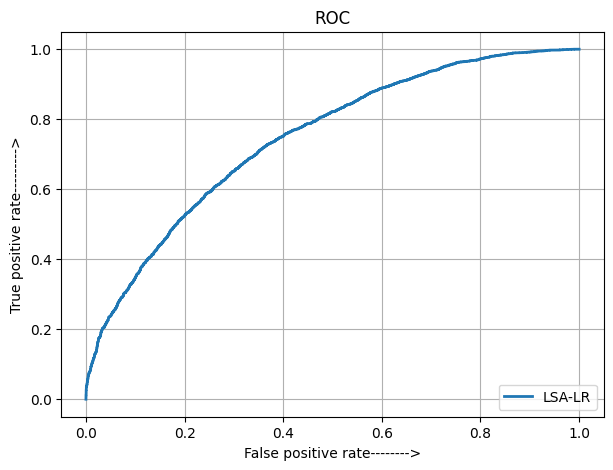

In [ ]:
import pickle
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=1)
clf.fit(x,y)
# pickle.dump(clf,open('/content/drive/MyDrive/HMD_project/new/RF_classifier.pkl','wb'))

y_pred_p=clf.predict_proba(x)

b=y_pred_p[:,-1]
b=b.reshape(y.shape)
fpr,tpr,th=roc_curve(y,b)

plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='LSA-LR',linewidth=2)

plt.grid()
plt.title("ROC")
plt.xlabel("False positive rate-------->")
plt.ylabel("True positive rate--------->")
plt.legend(loc='lower right')


optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = th[optimal_idx]
print('optimal_threshold', optimal_threshold,'\n')


In [ ]:
y_pred = np.where(clf.predict_proba(x)[:,1] >  0.47, 1, 0)

print(classification_report(y,y_pred))
print(matthews_corrcoef(y,y_pred))

print("\n\nvalidation")
y_pred_val = np.where(clf.predict_proba(x_val)[:,1] >  0.47, 1, 0)
print(classification_report(y_val,y_pred_val))
print(matthews_corrcoef(y_val,y_pred_val))

              precision    recall  f1-score   support

         0.0       0.70      0.61      0.66      5450
         1.0       0.66      0.74      0.70      5450

    accuracy                           0.68     10900
   macro avg       0.68      0.68      0.68     10900
weighted avg       0.68      0.68      0.68     10900

0.35806052832833585


validation
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       250
           1       0.58      0.55      0.57       250

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.58       500
weighted avg       0.58      0.58      0.58       500

0.1562113406956392


# AdaBoost classifier

optimal_threshold 0.4999166448147436 



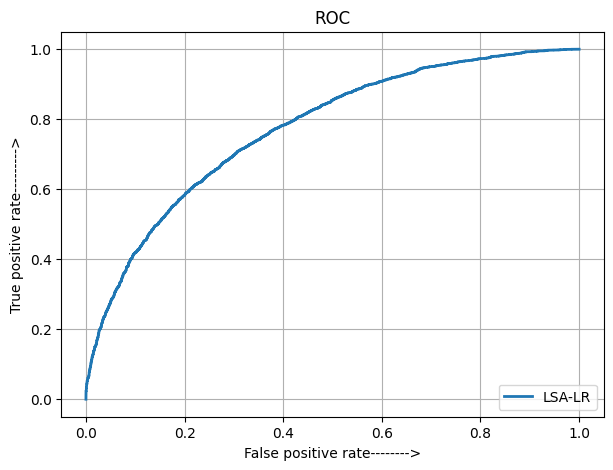

In [ ]:
clf = AdaBoostClassifier(n_estimators=80, learning_rate=1.0, random_state=42)
clf.fit(x,y)
# pickle.dump(clf,open('/content/drive/MyDrive/HMD_project/new/RF_classifier.pkl','wb'))

y_pred_p=clf.predict_proba(x)

b=y_pred_p[:,-1]
b=b.reshape(y.shape)
fpr,tpr,th=roc_curve(y,b)

plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='LSA-LR',linewidth=2)

plt.grid()
plt.title("ROC")
plt.xlabel("False positive rate-------->")
plt.ylabel("True positive rate--------->")
plt.legend(loc='lower right')


optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = th[optimal_idx]
print('optimal_threshold', optimal_threshold,'\n')

In [ ]:
y_pred = np.where(clf.predict_proba(x)[:,1] > 0.499, 1, 0)

print(classification_report(y,y_pred))
print(matthews_corrcoef(y,y_pred))

print("\n\nvalidation")
y_pred_val = np.where(clf.predict_proba(x_val)[:,1] > 0.499, 1, 0)
print(classification_report(y_val,y_pred_val))
print(matthews_corrcoef(y_val,y_pred_val))

              precision    recall  f1-score   support

         0.0       0.74      0.58      0.65      5450
         1.0       0.65      0.80      0.72      5450

    accuracy                           0.69     10900
   macro avg       0.70      0.69      0.68     10900
weighted avg       0.70      0.69      0.68     10900

0.3840318198665441


validation
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       250
           1       0.55      0.60      0.57       250

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.55       500
weighted avg       0.55      0.55      0.55       500

0.1084599780086928


# Gradient boosting classifier

optimal_threshold 0.5004591647309685 



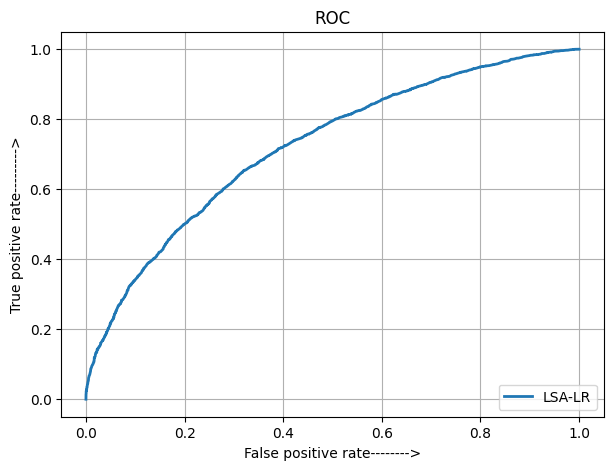

In [ ]:
clf = GradientBoostingClassifier(n_estimators=5, learning_rate=1.0, random_state=0)
clf.fit(x,y)
# pickle.dump(clf,open('/content/drive/MyDrive/HMD_project/new/RF_classifier.pkl','wb'))

y_pred_p=clf.predict_proba(x)

b=y_pred_p[:,-1]
b=b.reshape(y.shape)
fpr,tpr,th=roc_curve(y,b)

plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='LSA-LR',linewidth=2)

plt.grid()
plt.title("ROC")
plt.xlabel("False positive rate-------->")
plt.ylabel("True positive rate--------->")
plt.legend(loc='lower right')


optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = th[optimal_idx]
print('optimal_threshold', optimal_threshold,'\n')


In [ ]:
y_pred = np.where(clf.predict_proba(x)[:,1] > 0.48, 1, 0)

print(classification_report(y,y_pred))
print(matthews_corrcoef(y,y_pred))

print("\n\nvalidation")
y_pred_val = np.where(clf.predict_proba(x_val)[:,1] > 0.48, 1, 0)
print(classification_report(y_val,y_pred_val))
print(matthews_corrcoef(y_val,y_pred_val))

              precision    recall  f1-score   support

         0.0       0.67      0.64      0.65      5450
         1.0       0.66      0.69      0.67      5450

    accuracy                           0.66     10900
   macro avg       0.66      0.66      0.66     10900
weighted avg       0.66      0.66      0.66     10900

0.3268263160791555


validation
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       250
           1       0.59      0.53      0.56       250

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.58       500
weighted avg       0.58      0.58      0.58       500

0.1607424155354975
